In [2]:
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.plot import show
from matplotlib import colors
from skimage import exposure
from sklearn.metrics import confusion_matrix
import geopandas as gpd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import pickle

#plt.rcParams.update({'font.size': 20}) # Place at the start of your code in its own cell. It will change the fontsize for everything inside all subsequent plots.
figSize  = (12, 8)
fontSize = 22

In [3]:
def dir_location(date,band):
    directory  = '/vault/users/dara104/CleanedImage/*'+band+'*'+date+'*tif'
    bands      = glob.glob(directory)
    img        = rasterio.open(bands[0])
    return img

# Get all image pixels
def allPixels(date):
    all_df = pd.DataFrame()
    df_ls = []
    blue_band = dir_location(date,band = 'blue')
    green_band = dir_location(date,band = 'green')
    red_band = dir_location(date,band = 'red')
    nir_band = dir_location(date,band = 'nir')
    swir_band = dir_location(date,band = 'swir')
    
    df_ls.append(pd.DataFrame({'Blue_Band':blue_band.read(1)[2000:5000,1000:6000].ravel(),
                              'Green_Band':green_band.read(1)[2000:5000,1000:6000].ravel(),
                              'Red_Band':red_band.read(1)[2000:5000,1000:6000].ravel(),
                              'NIR_Band':nir_band.read(1)[2000:5000,1000:6000].ravel(),
                              'SWIR_Band':swir_band.read(1)[2000:5000,1000:6000].ravel()}))

    all_df = pd.concat(df_ls, axis=0)
    return all_df

In [4]:
# The dates of the images of interest
dates = ['2013', '2014', '2015', '2016', '2017', '2018']

In [27]:
# Load the saved model
fit_model = pickle.load(open('/vault/users/dara104/opt_model', 'rb'))

In [70]:
for year in dates[5]:
#     red = glob.glob('/vault/users/dara104/CleanedImage/*red*'+year+'*tif')
#     green = glob.glob('/vault/users/dara104/CleanedImage/*green*'+year+'*tif')
#     blue = glob.glob('/vault/users/dara104/CleanedImage/*blue*'+year+'*tif')
#     nir = glob.glob('/vault/users/dara104/CleanedImage/*nir*'+year+'*tif')
#     swir = glob.glob('/vault/users/dara104/CleanedImage/*swir*'+year+'*tif')
    
    pred_pixels = allPixels(date=year)

    ndvi_pred         = (pred_pixels.NIR_Band - pred_pixels.Red_Band)/(pred_pixels.NIR_Band + pred_pixels.Red_Band)
    ndwi_pred         = (pred_pixels.Green_Band - pred_pixels.NIR_Band)/(pred_pixels.Green_Band + pred_pixels.NIR_Band)
    ndbi_pred         = (pred_pixels.SWIR_Band - pred_pixels.NIR_Band)/(pred_pixels.SWIR_Band + pred_pixels.NIR_Band)
    pred_pixels['NDVI'] = ndvi_pred
    pred_pixels['NDWI'] = ndwi_pred
    pred_pixels['NDBI'] = ndbi_pred
    pred_pixels['BU']   = ndbi_pred - ndvi_pred

#     test_set = pred_pixels.fillna(-999)
    
#     #print(test_set.describe())
    
#     pred_img  = test_set.iloc[:,:].values
#     pred_class = fit_model.predict(pred_img)

#     land_pred = pred_class.reshape(3000,5000)
    
#     # Crop out the sea water and save the numpy array
#     no_sea = land_pred[0:3000,1000:5000]
#     np.save('/vault/users/dara104/Classified_Arrays/'+ year ,no_sea)
    
#     # Saving the plots
#     classes = ["No Data","Water","Urban","Farm","Forest","Bareland"]
#     fig = plt.figure(figsize=(15,15))
#     cmap = plt.cm.get_cmap("Set1",6)
#     plt.imshow(no_sea, cmap=cmap)
#     colorbar = plt.colorbar(ticks=ticks, orientation = "horizontal")
#     colorbar.set_ticklabels(classes)
#     plt.savefig(year+'.png')
#     plt.close(fig)
    
    

In [71]:
pred_pixels.head()

,Blue_Band,Green_Band,Red_Band,NIR_Band,SWIR_Band,NDVI,NDWI,NDBI,BU
0,0.0168,0.0197,0.0075,0.0026,0.0013,-0.485149,0.766816,-0.333333,0.151815
1,0.0170,0.0192,0.0077,0.0029,0.0012,-0.452830,0.737557,-0.414634,0.038196
2,0.0170,0.0193,0.0073,0.0028,0.0013,-0.445545,0.746606,-0.365854,0.079691
3,0.0170,0.0197,0.0076,0.0024,0.0014,-0.520000,0.782805,-0.263158,0.256842
4,0.0166,0.0197,0.0074,0.0024,0.0013,-0.510204,0.782805,-0.297297,0.212907


In [5]:
data = pd.DataFrame()

In [7]:
classes = ["Water","Urban","Farm","Forest","Bareland"]
total_area=[]
for year in dates:
        label_arr = np.load('/vault/users/dara104/Classified_Arrays/'+year+'.npy')
        label_bound = label_arr[1500:2000,1000:1500]
        area = label_bound.shape[0]*30*label_bound.shape[1]*30
        total_area.append(area)
        unique, counts = np.unique(label_bound, return_counts=True)
        print(unique, counts)
        class_counts = pd.DataFrame({"Classes":unique,
                                     "Class Names": classes,
                                    "Count":counts,
                                    "Area (m$^{2}$)":counts*900,
                                    "Year":year})
        data = data.append(class_counts)

[2 3 4 5 6] [    18  96262   3923    171 149626]
[2 3 4 5 6] [    19 136428  35487   2705  75361]
[2 3 4 5 6] [    10  25605 200272  21871   2242]
[2 3 4 5 6] [    14 150748  23949   2460  72829]
[2 3 4 5 6] [     5 209091  17357   2771  20776]
[2 3 4 5 6] [    11  92882 127038   3945  26124]


In [15]:
total_area

[225000000, 225000000, 225000000, 225000000, 225000000, 225000000]

In [19]:

urban_data = data[data['Class Names']=='Urban']
urban_percentage = (urban_data['Area (m$^{2}$)']/total_area[0])*100
urban_data['urban_percentage'] = urban_percentage
urban_data  

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Classes,Class Names,Count,Area (m$^{2}$),Year,urban_percentage
1,3,Urban,96262,86635800,2013,38.5048
1,3,Urban,136428,122785200,2014,54.5712
1,3,Urban,25605,23044500,2015,10.2420
1,3,Urban,150748,135673200,2016,60.2992
1,3,Urban,209091,188181900,2017,83.6364
1,3,Urban,92882,83593800,2018,37.1528


In [18]:
farm_data = data[data['Class Names']=='Farm']
farm_percentage = (farm_data['Area (m$^{2}$)']/total_area[0])*100
farm_data['farm_percentage'] = farm_percentage
farm_data

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Classes,Class Names,Count,Area (m$^{2}$),Year,farm_percentage
2,4,Farm,3923,3530700,2013,1.5692
2,4,Farm,35487,31938300,2014,14.1948
2,4,Farm,200272,180244800,2015,80.1088
2,4,Farm,23949,21554100,2016,9.5796
2,4,Farm,17357,15621300,2017,6.9428
2,4,Farm,127038,114334200,2018,50.8152


In [33]:
water_data = data[data['Class Names']=='Water']
water_percentage = (water_data['Area (m$^{2}$)']/total_area[0])*100
water_data['water_percentage'] = water_percentage
water_data

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Classes,Class Names,Count,Area (m$^{2}$),Year,water_percentage
0,2,Water,18,16200,2013,0.0072
0,2,Water,19,17100,2014,0.0076
0,2,Water,10,9000,2015,0.0040
0,2,Water,14,12600,2016,0.0056
0,2,Water,5,4500,2017,0.0020
0,2,Water,11,9900,2018,0.0044


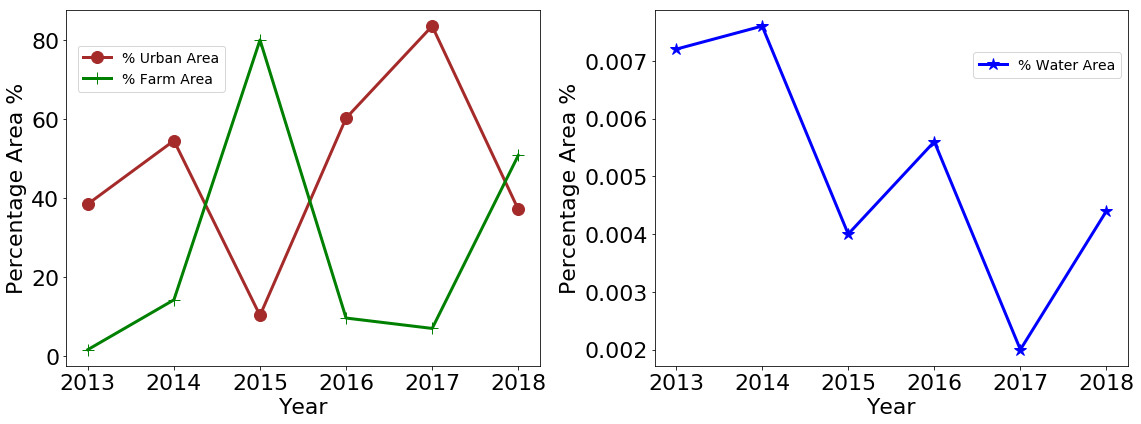

In [60]:
figSize  = (16,6)
fontSize = 22
plt.figure(figsize=figSize)
plt.subplot(121)
plt.plot(urban_data.Year, urban_data.urban_percentage,label='% Urban Area',marker='o', color ='brown',markersize=12,lw=3)
plt.plot(farm_data.Year, farm_data.farm_percentage,label='% Farm Area',marker='+', color ='green', markersize=12,lw=3)
plt.xlabel("Year",fontsize=fontSize)
plt.ylabel("Percentage Area %",fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(0.35,0.75))

plt.subplot(122)
plt.plot(water_data.Year, water_data.water_percentage,label='% Water Area',marker='*', color ='blue', markersize=12, lw=3)
plt.xlabel("Year",fontsize=fontSize)
plt.ylabel("Percentage Area %",fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(1.0,0.9))
plt.tight_layout()
plt.savefig('Farm_Urban_water_area.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [64]:
grouped = data.pivot_table('Area (m$^{2}$)',index = 'Year', columns = 'Class Names')
grouped
#plt.imshow(data['Year'])

Class Names,Bareland,Farm,Forest,No Data,Urban,Water
Year,,,,,,
2013,3074937300,611951400,909668700,1998000,6148631700,52812900
2014,1668177900,1488969000,1501899300,2982600,6071061600,66909600
2015,366875100,3398536800,2117320200,26556300,4837875300,52836300
2016,1642095000,1069173000,1172282400,6994800,6855512400,53942400
2017,1103614200,1169014500,1042902900,8297100,7438320900,37850400
2018,1149274800,2746566900,1205958600,13842900,5627256300,57100500


<Figure size 864x576 with 0 Axes>

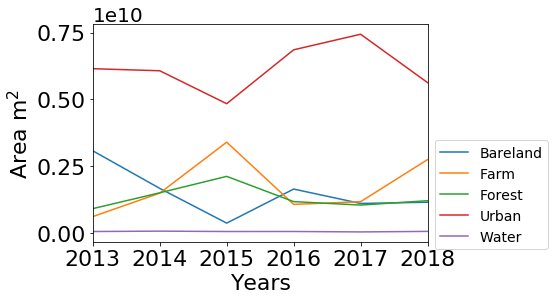

In [93]:
plt.figure(figsize=figSize)
rmv_no_data = grouped.drop('No Data', axis = 1)
rmv_no_data.plot()
plt.ylabel("Area m$^{2}$",fontsize=fontSize)

plt.xlabel("Years",fontsize=fontSize)

plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(1,0.5))


In [ ]:
plt.figure(figsize=figSize)
plt.hist(extracted_period,color='b',alpha=0.5,label='Extracted Period',rasterized=True)
plt.hist(crts_period,color='r',alpha=0.3, label='CRTS Period',rasterized=True)
plt.xlabel("Period in Days",fontsize=fontSize)
plt.ylabel("Number of stars",fontsize=fontSize)
plt.tick_params(axis='both', labelsize=fontSize)
plt.legend(loc="best",prop={'size':14},bbox_to_anchor=(1,0.5))
plt.savefig(file_name+'.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show(')

Text(0, 0.5, 'Area m$^{2}$')

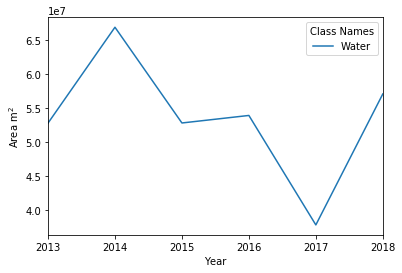

In [83]:
rmv_no_data[['Water']].plot()
plt.ylabel("Area m$^{2}$")

In [10]:
pwd

'/vault/users/dara104'

In [95]:
num_arrs = glob.glob("/vault/users/dara104/Classified_Arrays/*.npy")
def implt(arr,cmap):
    plt.figure(figsize=figSize)
    #cmap = plt.cm.get_cmap("Set1",6)
    #zoomed = np.load(arr)
    #plt.imshow(zoomed[1500:2000,1000:1500], cmap = cmap)
    plt.imshow(arr, cmap = cmap)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    #ticks = np.arange(1,7)
    colorbar = plt.colorbar(orientation = "vertical")
    #colorbar.set_ticklabels(classes)
    plt.savefig('NDBI.pdf', bbox_inches='tight', pad_inches=0.1)
# for array in num_arrs:
#     implt(array)
    

In [13]:
num_arrs

[]

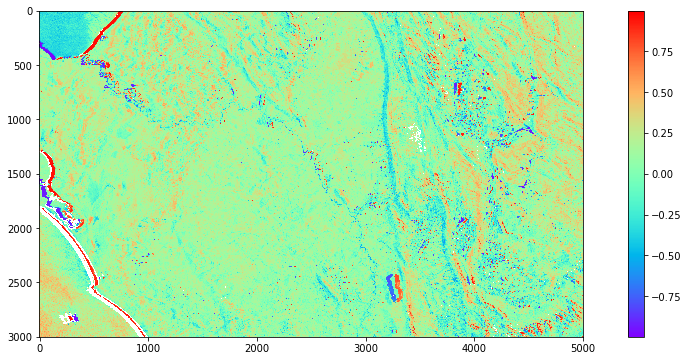

In [98]:
ndbi_arr = pred_pixels.NDBI.values.reshape(3000,5000)
implt(ndbi_arr,cmap='rainbow')